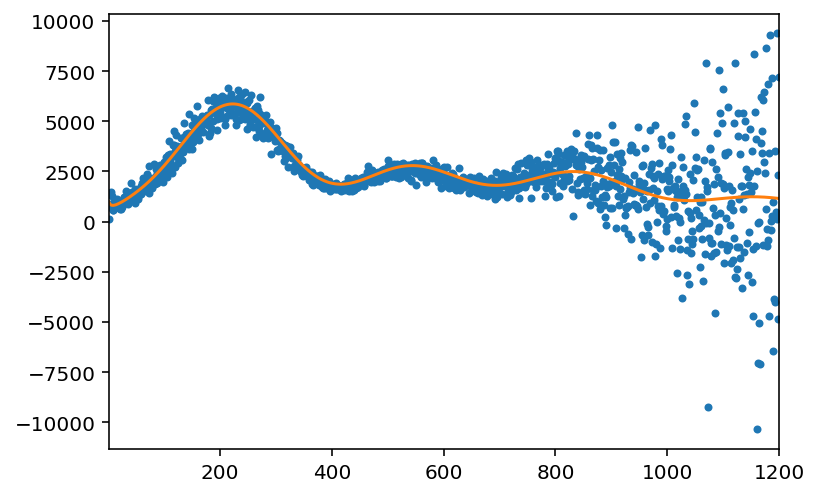

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import pyplot as plt
import time
import camb


def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('/Users/jmlascar/wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

axes = plt.gca()
axes.set_xlim([2,1200])

cmb=get_spectrum(pars)
cmb_cut=cmb[2:1199+2]
plt.plot(cmb_cut)
chisq=np.sum((cmb_cut-wmap[:,1])**2/(wmap[:,2])**2)



newton loop  0
Chi squared changes by 0.0
[6.72536137e+01 2.24524115e-02 1.16270328e-01 2.07029927e-09
 9.66267272e-01]
newton loop  1
Chi squared changes by 352.58467603179156
[6.92399102e+01 2.24914411e-02 1.14114321e-01 2.04387761e-09
 9.69599405e-01]
newton loop  2
Chi squared changes by 7.715028504631164
[6.92851952e+01 2.24888199e-02 1.14015741e-01 2.04320315e-09
 9.69646178e-01]
newton loop  3
Chi squared changes by 0.0017169059615298465
[6.92895347e+01 2.24894138e-02 1.14007485e-01 2.04316007e-09
 9.69663968e-01]
newton loop  4
Chi squared changes by 6.537464946632099e-05
[6.92896291e+01 2.24894300e-02 1.14007295e-01 2.04315934e-09
 9.69664433e-01]
error is [[ 5.84571626e+00  7.51688942e-04 -1.10703110e-02 -6.34071163e-11
   2.29341791e-02]
 [ 7.51688942e-04  2.91382632e-07 -6.07624688e-07  1.82354270e-15
   6.09117844e-06]
 [-1.10703110e-02 -6.07624688e-07  2.75536677e-05  1.89687300e-13
  -3.13583909e-05]
 [-6.34071163e-11  1.82354270e-15  1.89687300e-13  1.54234238e-21
  -5.

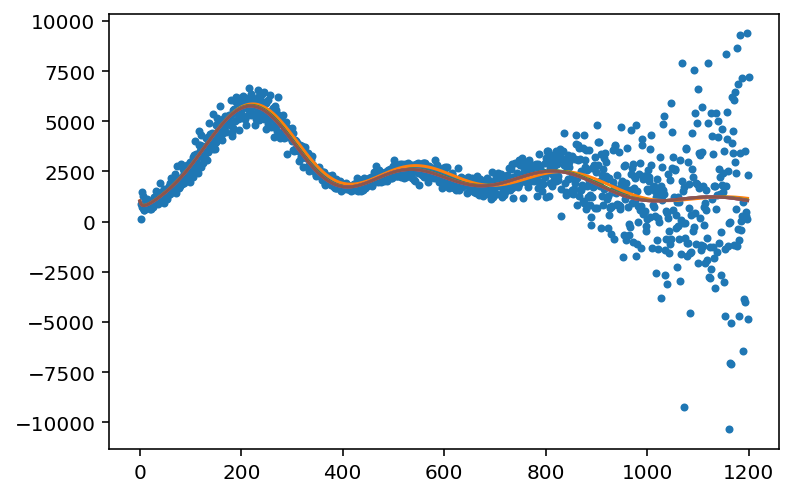

In [3]:
%matplotlib inline
plt.plot(wmap[:,0],wmap[:,1],'.')
def get_spectrum_tau(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    As=pars[3]
    ns=pars[4]
    tau=0.05
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,tau=tau,mnu=0.06,omk=0)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


def get_derivs_tau(f,pars):
    df=np.zeros((1199,len(pars)))
    dx=[0.1,0.001,0.01,1e-10,0.01]
    add=np.zeros(len(pars))
    for i in range(len(pars)):
            d=1/(2*dx[i])
            add[i]=dx[i]
            df[:,i]=(f(pars+add)[2:1201]-f(pars-add)[2:1201])*d
            add=np.zeros(len(pars))
    return df

pars=np.asarray([65,0.02,0.1,2e-9,0.96])
y=wmap[:,1]
guess=cmb_cut.copy()

chi_old=np.sum((cmb_cut-wmap[:,1])**2/(wmap[:,2])**2)
chi_thresh=0.01
L=0.001
for i in range(5):
    print("newton loop ",i)
    pars_old=pars.copy()
    guess2 = get_spectrum_tau(pars)
    plt.plot(guess2[2:1201])
    cmb_cut=guess2[2:1201]
    derivs=get_derivs_tau(get_spectrum_tau,pars)
    
    resid = y-cmb_cut #residual
    N=np.diag(wmap[:,2]**2) #noise
    #solving for Am^T.N^-1.Am.dm=Am^TN^-1r
    AN=np.dot(np.transpose(derivs),np.linalg.inv(N)) 
    rhs=np.dot(AN,derivs)
    lhs=np.dot(AN,resid)
    dm=np.dot(np.linalg.inv(rhs),lhs)
    chi_new = np.sum((resid**2)/(wmap[:,2]**2))
    pars = pars_old+dm
    print("Chi squared changes by",chi_old-chi_new)
    chi_old = chi_new
    #covariance matrix: diagonal, has the errors^2 in the diag: 
    mycov=np.linalg.inv(rhs)
          
newton_pars= pars
newton_guess = get_spectrum_tau(newton_pars)
print("Our best guess of parameters is ",pars)
plt.show()


In [7]:
mycov=error
Err=np.sqrt(np.diag(mycov))
print(Err)

[2.41779161e+00 5.39798695e-04 5.24915876e-03 3.92726671e-11
 1.36022901e-02]


The errors from our analysis for a parameter P is of the order of Pe-2. 
If we were to keep tau floating, we can estimate that the errors would be roughly the same and that the error for tau would be about 0.0005. 

In [21]:
err_tau= [2.41779161e+00,5.39798695e-04,5.24915876e-03,0.0005,3.92726671e-11,1.36022901e-02]
#now to get our covariance matrix
covmat=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        covmat[i,j]=err_tau[i]*err_tau[j]


[[5.84571627e+00 1.30512076e-03 1.26913720e-02 1.20889581e-03
  9.49531250e-11 3.28875029e-02]
 [1.30512076e-03 2.91382631e-07 2.83348905e-06 2.69899348e-07
  2.11993344e-14 7.34249844e-06]
 [1.26913720e-02 2.83348905e-06 2.75536677e-05 2.62457938e-06
  2.06148465e-13 7.14005802e-05]
 [1.20889581e-03 2.69899348e-07 2.62457938e-06 2.50000000e-07
  1.96363336e-14 6.80114505e-06]
 [9.49531250e-11 2.11993344e-14 2.06148465e-13 1.96363336e-14
  1.54234238e-21 5.34198211e-13]
 [3.28875029e-02 7.34249844e-06 7.14005802e-05 6.80114505e-06
  5.34198211e-13 1.85022296e-04]]
0.001305120755859949


In [29]:
def take_step_cov(covmat): 
    return np.dot(covmat,np.random.randn(covmat.shape[0]))


params=[6.92896291e+01, 2.24894300e-02, 1.14007295e-01, 0.05, 2.04315934e-09,
 9.69664433e-01]

npar=len(params)
nstep=500
y=wmap[:,1]
cmb=get_spectrum(params)[2:1201]
chains_new=np.zeros([nstep,npar])
chisq=np.sum( (y-cmb)**2/wmap[:,2]**2)
scale_fac=0.5
chisqvec_new=np.zeros(nstep)
r=0
for i in range(nstep):#use
    print("loop ",i)
    new_params=params+take_step_cov(covmat)*scale_fac #mycov: uses the covariane matrix
    new_model=get_spectrum(new_params)[2:1201]
    new_chisq=np.sum( (y-new_model)**2/(wmap[:,2]**2))
    
    delta_chisq=new_chisq-chisq
    prob=np.exp(-0.5*delta_chisq)
    accept=np.random.rand(1)<prob
    if accept:
        params=new_params
        model=new_model
        chisq=new_chisq
        ratio=r+1
    chains_new[i,:]=params
    chisqvec_new[i]=chisq
    
fit_params=np.mean(chains_new,axis=0)
print(fit_params)
print("Out of ",nstep,",",r," were accepted")

loop  0
loop  1
loop  2
loop  3
loop  4
loop  5
loop  6
loop  7
loop  8
loop  9
loop  10
loop  11
loop  12
loop  13
loop  14
loop  15
loop  16
loop  17
loop  18
loop  19
loop  20
loop  21
loop  22
loop  23
loop  24
loop  25
loop  26
loop  27
loop  28
loop  29
loop  30
loop  31
loop  32
loop  33
loop  34
loop  35
loop  36
loop  37
loop  38
loop  39
loop  40
loop  41
loop  42
loop  43
loop  44
loop  45
loop  46
loop  47
loop  48
loop  49
loop  50
loop  51
loop  52
loop  53
loop  54
loop  55
loop  56
loop  57
loop  58
loop  59
loop  60
loop  61
loop  62
loop  63
loop  64
loop  65
loop  66
loop  67
loop  68
loop  69
loop  70
loop  71
loop  72
loop  73
loop  74
loop  75
loop  76
loop  77
loop  78
loop  79
loop  80
loop  81
loop  82
loop  83
loop  84
loop  85
loop  86
loop  87
loop  88
loop  89
loop  90
loop  91
loop  92
loop  93
loop  94
loop  95
loop  96
loop  97
loop  98
loop  99
loop  100
loop  101
loop  102
loop  103
loop  104
loop  105
loop  106
loop  107
loop  108
loop  109
loop  110


In [ ]:
labels = ['H0','ombh2','omch2','tau','As','ns']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])